<div align="right"><h5>Обыденкова Ю.Ю.</h5></div>

<div align="right"><h5>группа: M8О-408Б-18, №14 по списку</h5></div>

<h1><center>Лабораторная работа №5</center></h1>

***Задание:*** Используя *явную и неявную конечно-разностные схемы*, а также *схему Кранка - Николсона*, решить начально-краевую задачу для дифференциального уравнения параболического типа.
Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: *двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком.*
В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h$.

### <center> Вариант №4 </center>

In [12]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import random
import matplotlib.pyplot as plt
import math
import sys
import warnings
import numpy as np
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D

***Уравнение:***

$$\displaystyle\frac{\partial u}{\partial t} = a \displaystyle\frac{\partial^2 u}{\partial x^2}, \; a > 0$$

***Граничные условия:***

\begin{equation*}
 \begin{cases}
   u_{x}' (0, \: t) = \phi_0(t) = e^{-at}
   \\
   u_{x}' (\pi, \: t) = \phi_l(t) = -e^{-at}
   \\
   u(x, \: 0) = \sin{x}
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, t) = e^{-at} \sin{x}$$

In [13]:
# conditions:
def phi_0(t, a = 1.0):
    return math.exp(-a*t)

def phi_l(t, a = 1.0):
    return -math.exp(-a*t)

def u_0(x):
    return math.sin(x)

# analytic solve
def u(x, t, a = 1.0):
    return math.exp(-a*t)*math.sin(x)

## <center> Конечно-разностная схема </center>

<h3><center> Общая концепция </center></h3>

Будем решать задачу на заданном промежутке  от $0$ до $l$ по координате $x$ и на промежутке от $0$ до заданного параметра $T$ по времени $t$.

Рассмотрим конечно-разностную схему решения краевой задачи на сетке с граничными парамерами $l$, $T$ и параметрами насыщенности сетки $N$, $K$. Тогда размер шага по каждой из координат определяется:
$$h = \displaystyle\frac{l}{N}, \; \tau = \displaystyle\frac{T}{K}$$

Считая, что значения функции $u^k_j = u(x_j, t^k)$ для всех координат $x_j = j h, \; \forall j \in \{0, ..., N\}$ на временном слое $t^k = k \tau, \; k \in \{0, ..., K - 1\}$ известно, попробуем определить значения функции на временном слое $t^{k+1}$ путем разностной апроксимации производной:
$$\displaystyle\frac{\partial u}{\partial t}(x_j, t^k) = \displaystyle\frac{u^{k+1}_j - u^k_j}{\tau}$$

И одним из методов апроксимации второй производной по $x$:
$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k)$$

In [14]:
# class will return grid of values
class Schema:
    def __init__(self, a = 1, f0 = phi_0, fl = phi_l, u0 = u_0, 
                 O = 0.5, l0 = 0, l1 = math.pi, T = 5, aprx_cls = None):
        self.fl = lambda t: fl(t, a)
        self.f0 = lambda t: f0(t, a)
        self.u0 = u0
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None
        self.h = None
        self.a = a
        self.O = O
        self.approx = None
        if aprx_cls is not None:
            self._init_approx(aprx_cls)
        self.sigma = None
        
    def _init_approx(self, a_cls):
        self.approx = a_cls(self.f0, self.fl)
    
    def set_approx(self, aprx_cls):
        self._init_approx(self, aprx_cls)
        
    def set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1
        
    def set_T(self, T):
        self.T = T
        
    def _compute_h(self, N):
        self.h = (self.l1 - self.l0) / N
        
    def _compute_tau(self, K):
        self.tau = self.T / K
        
    def _compute_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
        
    def _compute_line(self, t, x, last_line):
        pass
    
    def __call__(self, N=30, K=110):
        # compute t and h
        N, K = N-1, K-1
        self._compute_tau(K)
        self._compute_h(N)
        self._compute_sigma()
        ans = []
        # compute x:
        x = list(self.nparange(self.l0, self.l1, self.h))
        # compute first line
        last_line = list(map(self.u0, x))
        # add copy
        ans.append(list(last_line))
        X = []
        Y = []
        X.append(x)
        Y.append([0.0 for _ in x])
        # main loop
        for t in self.nparange(self.tau, self.T, self.tau):
            # append new line
            ans.append(self._compute_line(t, x, last_line))
            X.append(x)
            Y.append([t for _ in x])
            # take new line as last
            last_line = ans[-1]
        return X, Y, ans

<h3><center> Явная конечно-разностная схема </center></h3>

Апроксимируем вторую производную по значениям нижнего временного слоя $t^k$, а именно:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k) = \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2}$$

Тогда получим явную схему конечно-разностного метода во внутренних узлах сетки:

$$\displaystyle\frac{u^{k+1}_j - u^k_j}{\tau} = a \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2}, \; \forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$$

Обозначим $\sigma = \displaystyle\frac{a \tau}{h^2}$, тогда:

$$u^{k+1}_j = \sigma u^k_{j-1} + (1 - 2\sigma)u^k_j + \sigma u^k_{j+1}$$

Граничные же значения $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями $u_x(0, t) = \phi_0(t)$ и $u_x(l, t) = \phi_l(t)$ при помощи апроксимации производной.

*Значение $\sigma$ используется для анализа устойчивости решения, а именно решение устойчиво, если $\sigma \leq \displaystyle\frac{1}{2}$*.

In [15]:
class Explict_Schema(Schema):
    def _compute_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
        if self.sigma > 0.5:
            warnings.warn("Sigma > 0.5")
        
    def _compute_line(self, t, x, last_line):
        line = [None for _ in last_line]
        for i in range(1, len(x) - 1):
            line[i] = self.sigma*last_line[i-1] 
            line[i] += (1 - 2*self.sigma)*last_line[i]
            line[i] += self.sigma*last_line[i+1]
        line[0] = self.approx.explict_0(t, self.h, self.sigma, 
                                        last_line, line, t - self.tau)
        line[-1] = self.approx.explict_l(t, self.h, self.sigma, 
                                         last_line, line, t - self.tau)
        return line

<h3><center>Неявная конечно-разностная схема</center></h3>

Апроксимируем вторую производную по значениям верхнего временного слоя $t^{k+1}$, а именно:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k) = \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2}$$

Тогда получим явную схему конечно-разностного метода во внутренних узлах сетки:

$$\displaystyle\frac{u^{k+1}_j - u^k_j}{\tau} = a \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2}, \; \forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$$

Обозначим $\sigma = \displaystyle\frac{a \tau}{h^2}$. Тогда значения функции на слое можно найти эффективны образом с помощью методом прогонки, где **СЛАУ**, кроме крайних двух уравнений, определяется коэффицетнами $a_j = \sigma$, $b_j = -(1 + 2\sigma)$, $c_j = \sigma$, $d_j = -u^k_j$ уравнений:

$$a_j u^{k+1}_{j - 1} + b_j u^{k+1}_j + c_j u^{k+1}_{j+1} = d_j, \; \forall j \in \{1, ..., N-1\}$$

Первое и последнее уравнение системы содержащие $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями $u_x(0, t) = \phi_0(t)$ и $u_x(l, t) = \phi_l(t)$ при помощи апроксимации производной.

*Неявная схема является абсолютно устойчивой*.

In [16]:
# implict schema is krank-nikolson(O = 1)

<h3><center>Схема Кранка-Николсона</center></h3>

Поскольку как правило решение в зависимости от времени лежит между значениями явной и неявной схемы, имеет смысл получить смешанную апроксимацию пространственных производных.

<img src="img/graphic.png" alt="graphic" title="Graphic"/>

*Явно-неявная схема* для $\forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$ будет выглядеть следующим образом:

$$\displaystyle\frac{u^{k+1}_j - u^k_j}{\tau} = \theta a \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2} + (1 - \theta) a \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2}$$

При значении параметра $\theta = \displaystyle\frac{1}{2}$ схема являет собой *схему Кранка-Николсона*.

Обозначим $\sigma = \displaystyle\frac{a \tau}{h^2}$. Тогда значения функции на слое можно найти эффективны образом с помощью методом прогонки, где **СЛАУ**, кроме крайних двух уравнений, определяется коэффицетнами $a_j = \sigma \theta$, $b_j = -(1 + 2 \theta \sigma)$, $c_j = \sigma \theta$, $d_j = -(u^k_j + (1 - \theta) \sigma (u^k_{j-1} - 2u^k_j + u^k_{j+1}))$ уравнений:

$$a_j u^{k+1}_{j - 1} + b_j u^{k+1}_j + c_j u^{k+1}_{j+1} = d_j, \; \forall j \in \{1, ..., N-1\}$$

Первое и последнее уравнение системы содержащие $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями $u_x(0, t) = \phi_0(t)$ и $u_x(l, t) = \phi_l(t)$ при помощи апроксимации производной.

*Схема Кранка-Николсона является абсолютно устойчивой*.

In [17]:
class Explict_Implict(Schema):
    def set_O(self, O):
        self.O = O
    
    # method from old labs
    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x
    
    # compute line using race method
    def _compute_line(self, t, x, last_line):
        a = self.sigma * self.O
        b = -1 - 2 * self.sigma * self.O
        
        # coeffs
        A = [(a, b, a) for _ in range(1, len(x)-1)]
        w = [
            # expression
            -(last_line[i] + 
                (1 - self.O) * self.sigma*
                (last_line[i-1] - 2*last_line[i] + last_line[i+1])) 
            # for this idxs
            for i in range(1, len(x)-1)
        ]
        # compute coeffst for first and last equation
        koeffs = self.approx.nikolson_0(t, self.h, self.sigma, 
                                        last_line, self.O, t - self.tau)
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        koeffs = self.approx.nikolson_l(t, self.h, self.sigma, 
                                        last_line, self.O, t - self.tau)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        
        return self.race_method(A, w)

In [18]:
Krank_Nikolson = Explict_Implict

<h2><center> Апроксимация первых производных </center></h2>

In [19]:
class Approx:
    def __init__(self, f0, fl):
        self.f0 = f0
        self.fl = fl
        
    def explict_0(self, t, h, sigma, l0, l1, t0):
        pass
    def explict_l(self, t, h, sigma, l0, l1, t0):
        pass
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        pass
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        pass

<h3><center> Двухточечная первого порядка </h2></center>

Двухточечная апроксимация первого порядка в точке $x = 0$ и $x = l$ равны соответственно:
$$\displaystyle\frac{u^{k+1}_1 - u^{k+1}_0}{h} = \phi_0(t^{k+1})$$
$$\displaystyle\frac{u^{k+1}_N - u^{k+1}_{N-1}}{h} = \phi_l(t^{k+1})$$

Тогда, поскольку мы знаем значения для внутренних узлов, получаем выражения для граничных значений при явном методе:
$$u^{k+1}_0 = -h \phi_0(t^{k+1}) + u^{k+1}_1$$
$$u^{k+1}_N = h \phi_l(t^{k+1}) + u^{k+1}_{N-1}$$

И крайние уравенения для методда прогонки в неявном методе и в *схеме Кранка-Николсона*:
$$-u^{k+1}_0 + u^{k+1}_1 = h \phi_0(t^{k+1})$$
$$-u^{k+1}_{N-1} + u^{k+1}_N = h \phi_l(t^{k+1})$$

In [20]:
class approx_two_one(Approx):
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return -h * self.f0(t) + l1[1]
    
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return h * self.fl(t) + l1[-2]
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        return 0, -1, 1, h*self.f0(t)
    
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        return -1, 1, 0, h*self.fl(t)

<h3><center>Трёхточечная второго порядка</center></h3>

Трёхточечна апроксимация второго порядка в точке $x = 0$ и $x = l$ равны соответственно:
$$\displaystyle\frac{-3u^{k+1}_0 + 4u^{k+1}_1 - u^{k+1}_2}{2h} = \phi_0(t^{k+1})$$

$$\displaystyle\frac{3u^{k+1}_N - 4u^{k+1}_{N-1} + u^{k+1}_{N-2}}{2h} = \phi_l(t^{k+1})$$

Тогда, поскольку мы знаем значения для внутренних узлов, получаем выражения для граничных значений при явном методе:
$$u^{k+1}_0 = \displaystyle\frac{-2h \phi_0(t^{k+1}) + 4u^{k+1}_1 - u^{k+1}_2}{3}$$

$$u^{k+1}_N = \displaystyle\frac{2h \phi_l(t^{k+1}) + 4u^{k+1}_{N-1} - u^{k+1}_{N-2}}{3}$$

Крайние уравенения для методда прогонки в неявном методе:
$$-2 \sigma u^{k+1}_0 + (2\sigma - 1)u^{k+1}_1 = 2\sigma h \phi_0(t^{k+1}) - u^k_1$$
$$(2\sigma - 1)u^{k+1}_{N-1} - 2\sigma u^{k+1}_N = -2 \sigma h \phi_l(t^{k+1}) - u^k_{N-1}$$

И крайние уравнения для *схемы Кранка-Николсона*:
$$-2\sigma\theta u^{k+1}_{0} + (2\sigma\theta - 1)u^{k+1}_{1} = 2\sigma\theta h \phi_0(t^{k+1}) - (u^k_1 + (1 - \theta)\sigma(u^k_{0} - 2 u^k_{1} + u^k_{2})$$
$$(1 - 2\sigma\theta)u^{k+1}_{N-1} + 2\sigma\theta u^{k+1}_{N} = 2\sigma\theta h \phi_l(t^{k+1}) + (u^k_{N-1} + (1 - \theta)\sigma(u^k_{N-2} - 2 u^k_{N-1} + u^k_{N})$$

In [21]:
class approx_three_two(Approx):
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return (-2*h*self.f0(t) + 4*l1[1] - l1[2]) / 3
                
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return (2*h*self.fl(t) + 4*l1[-2] - l1[-3]) / 3
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.f0(t)
        d -= l0[1] + (1 - O)*sigma*(l0[0] - 2*l0[1] + l0[2])
        return 0, -2*sigma*O, 2*sigma*O - 1, d
    
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.fl(t)
        d += l0[-2] + (1 - O)*sigma*(l0[-3] - 2*l0[-2] + l0[-1])
        return 1 - 2*sigma*O, 2*sigma*O, 0, d

<h3><center> Двухточечная второго порядка </center></h3>

Двухточечная апроксимация второго порядка в точке $x = 0$ и $x = l$ равны соответственно:
$$\displaystyle\frac{u^{k+1}_1 - u^{k+1}_{-1}}{2h} = \phi_0(t^{k+1})$$

$$\displaystyle\frac{u^{k+1}_{N+1} - u^{k+1}_{N-1}}{2h} = \phi_l(t^{k+1})$$

Тогда, используя апроксимацию на предыдущем временном слое, а именно при $t = t^k$, и выразив значения, выходящие за пределы сетки с помощью уравнения:
$\displaystyle\frac{u^{k+1}_j - u^k_j}{\tau} = a \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2}$ для значений $j=0$ и $j = N$
мы получим формулу граничных значений для явной схемы:

$$u^{k+1}_0 = -2 \sigma h \phi_0(t^{k}) + 2\sigma u^{k}_1 + (1 - 2\sigma)u^{k}_0$$

$$u^{k+1}_N = 2 \sigma h \phi_l(t^{k}) + 2 \sigma u^{k}_{N-1} + (1 - 2 \sigma) u^{k}_{N}$$

Используя аппроксимацию на слое $t^{k+1}$ получим крайние уравенения для методда прогонки в неявном методе:
$$-(2\sigma+1)u^{k+1}_0 + 2\sigma u^{k+1}_1 = 2\sigma h\phi_0(t^{k+1}) - u^k_0$$
$$2\sigma u^{k+1}_{N-1} - (2\sigma+1)u^{k+1}_N = -2\sigma h\phi_l(t^{k+1}) - u^k_N$$

И крайние уравнения для *схемы Кранка-Николсона*:
$$-(2\theta\sigma+1)u^{k+1}_0 + 2\sigma\theta u^{k+1}_1 = 2\theta\sigma h\phi_0(t^{k+1}) - (u^k_0 + 2(1-\theta)\sigma(u^k_1 - u^k_0 - h\phi_0(t^k)))$$
$$2\sigma\theta u^{k+1}_{N-1} - (2\theta\sigma+1)u^{k+1}_N = -2\theta\sigma h\phi_l(t^{k+1}) - (u^k_N + 2(1-\theta)\sigma(u^k_{N-1} - u^k_N + h\phi_l(t^k)))$$

In [22]:
class approx_two_two(Approx):
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return -2*sigma*h*self.f0(t0) + \
                    2*sigma*l0[1] + (1 - 2*sigma)*l0[0]
                
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return 2*sigma*h*self.fl(t0) + \
                    2*sigma*l0[-2] + (1 - 2*sigma)*l0[-1]
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.f0(t) - l0[0]
        d -= 2*(1 - O)*sigma*(l0[1] - l0[0] - h*self.f0(t0))
        return 0, -(2*sigma*O + 1), 2*sigma*O, d
    
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = -2*sigma*O*h*self.fl(t) - l0[-1]
        d -= 2*(1 - O)*sigma*(l0[-2] - l0[-1] + h*self.fl(t0))
        return 2*sigma*O, -(2*sigma*O + 1), 0, d

<h2><center> Результаты работы </center></h2>

<h3><center> Зависимость погрешности от параметра $h$ </center></h3>

#### Вычисление погрешностей

Вычисление погрешности: $e = \| \hat{z} - z \|_2$, где $\hat{z}$,  $z$ - матрицы  вычесленных и реальных значений функции в сетке соответственно.

In [23]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return ans**0.5

Постоение зависимости погрешности от шага $h$.

In [24]:
def get_graphic_h(solver, real_f):
    h = []
    e = []
    for N in range(3, 50):
        x, y, z = solver(N)
        h.append(solver.h)
        e.append(epsilon(x, y, z, real_f))
    return h, e

#### Явная схема

In [25]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

<ipython-input-15-6bd7c55a9975>:5: UserWarning: Sigma > 0.5
  warnings.warn("Sigma > 0.5")


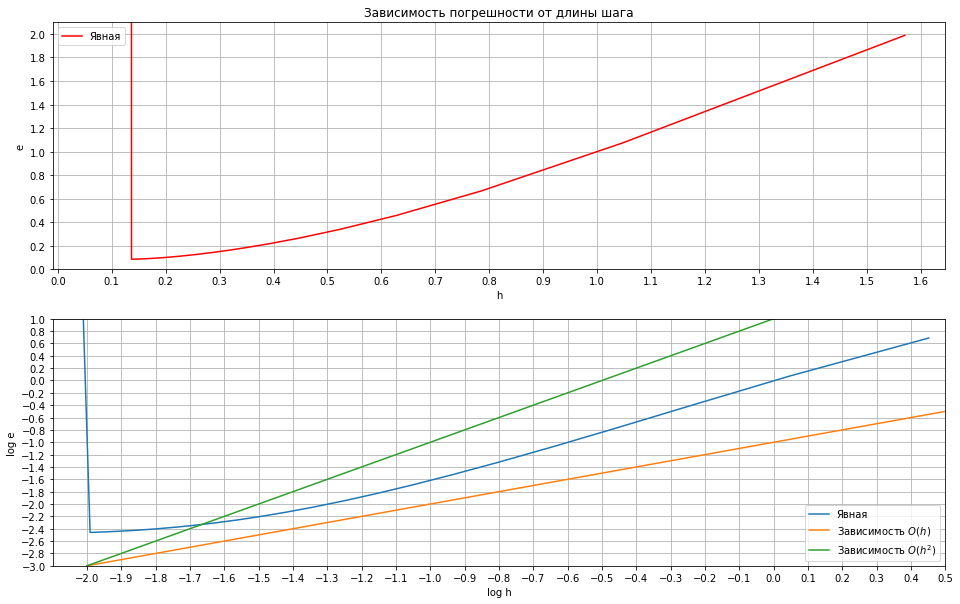

In [26]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(explict, u)

plt.plot(h, e, label="Явная", color = "red")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(explict.nparange(0, 1.6, 0.1)))
plt.yticks(list(explict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Явная")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2.1, 0.5])
plt.xticks(list(explict.nparange(-2, 0.5, 0.1)))
plt.yticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [29]:
# Krank Nikolson with O = 1 is implict schema
implict = Krank_Nikolson(T = 1, aprx_cls=approx_two_two, O=1)

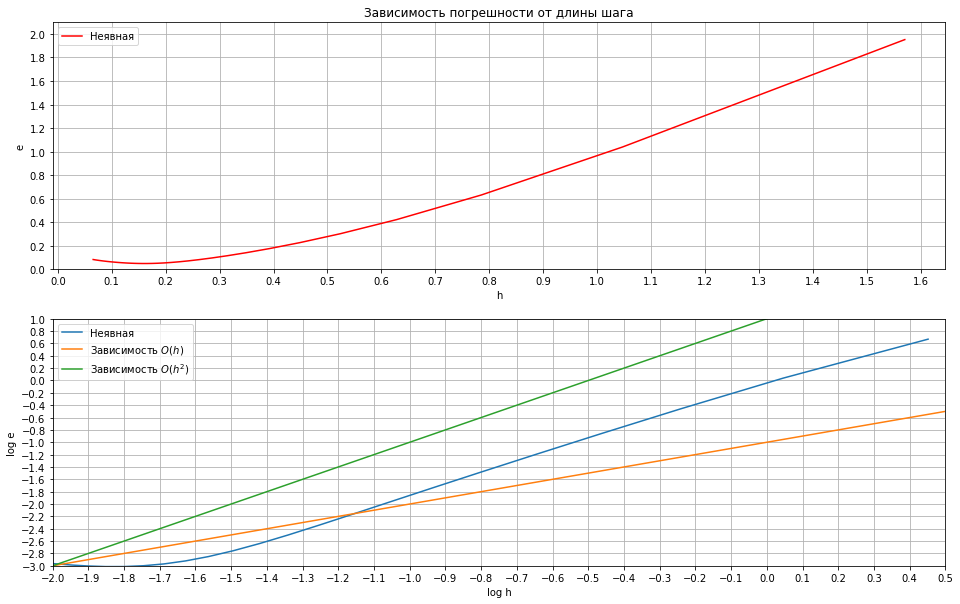

In [32]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(implict, u)

plt.plot(h, e, label="Неявная", color = "red")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(implict.nparange(0, 1.6, 0.1)))
plt.yticks(list(implict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Неявная")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2, 0.5])
plt.xticks(list(implict.nparange(-2, 0.5, 0.1)))
plt.yticks(list(implict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Схема Кранка-Николсона

In [33]:
krank = Krank_Nikolson(T = 1, aprx_cls=approx_two_two)

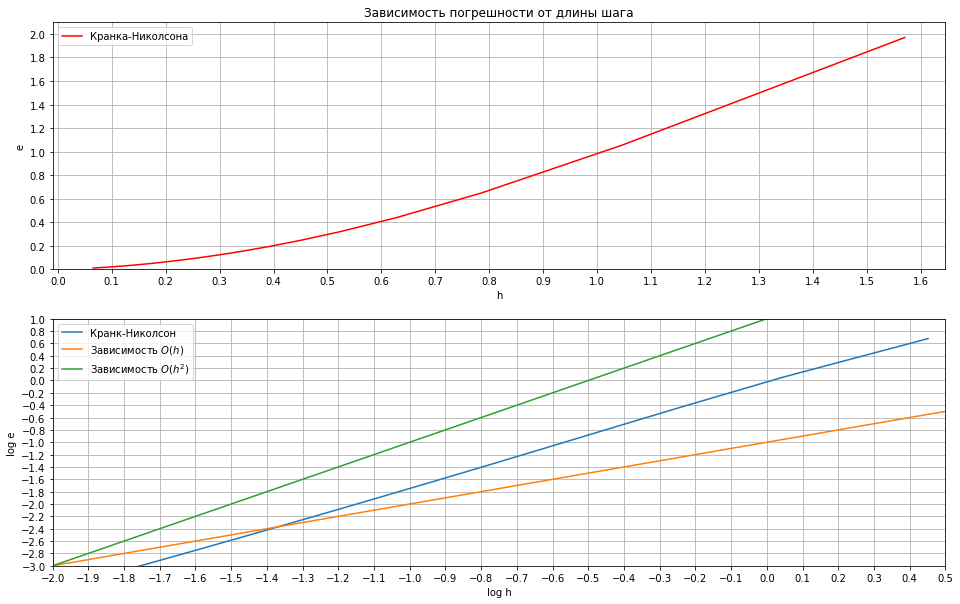

In [34]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(krank, u)

plt.plot(h, e, label="Кранка-Николсона", color = "red")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(krank.nparange(0, 1.6, 0.1)))
plt.yticks(list(krank.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Кранк-Николсон")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2, 0.5])
plt.xticks(list(krank.nparange(-2, 0.5, 0.1)))
plt.yticks(list(krank.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

<h3><center> Зависимость погрешности от параметра $\tau$ </center></h3>

#### Вычисление погрешности

Построение зависимости погрешности от параметра $\tau$.

In [35]:
def get_graphic_tau(solver, real_f):
    tau = []
    e = []
    for K in range(3, 90):
        x, y, z = solver(K = K)
        tau.append(solver.tau)
        e.append(epsilon(x, y, z, real_f))
    return tau, e

#### Явная схема

In [36]:
explict = Explict_Schema(T = 5, aprx_cls=approx_two_two)

<ipython-input-17-6bd7c55a9975>:5: UserWarning: Sigma > 0.5
  warnings.warn("Sigma > 0.5")


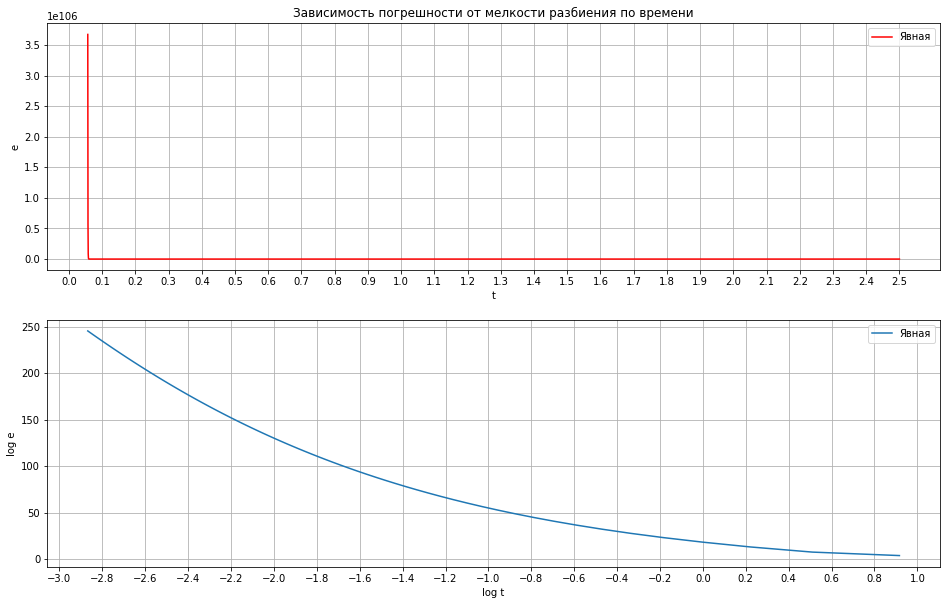

In [37]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(explict, u)

plt.plot(tau, e, label="Явная", color = "red")
plt.xlabel("t")
plt.ylabel("e")
# plt.ylim([0, 2.1])
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
# plt.yticks(list(explict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Явная")
plt.xlabel("log t")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2, 0.5])
plt.xticks(list(explict.nparange(-3, 1, 0.2)))
# plt.yticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [38]:
# Krank Nikolson with O = 1 is implict schema
implict = Krank_Nikolson(T = 5, aprx_cls=approx_two_two, O=1)

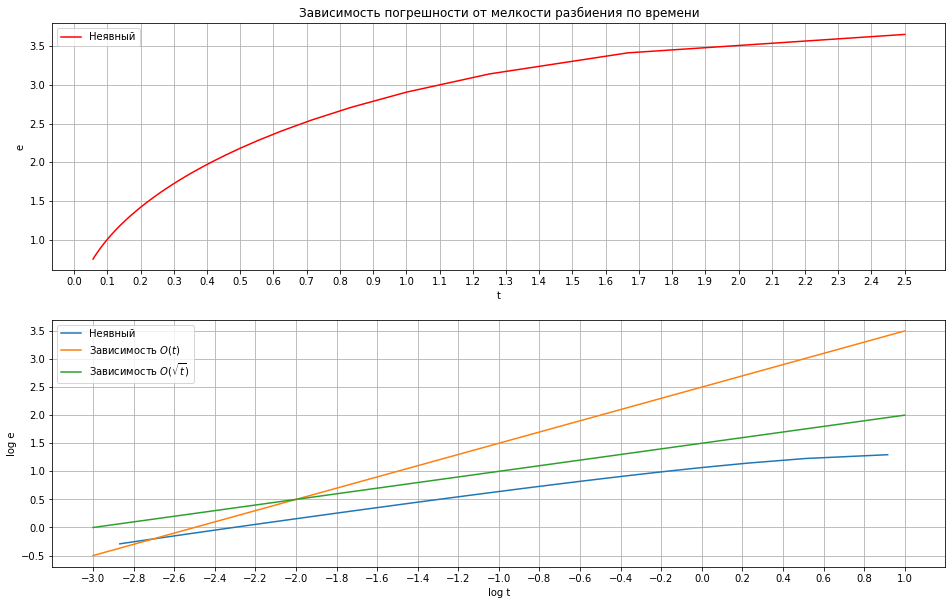

In [39]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(implict, u)

plt.plot(tau, e, label="Неявный", color = "red")
plt.xlabel("t")
plt.ylabel("e")
# plt.ylim([0, 2.1])
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
# plt.yticks(list(implict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Неявный")
plt.plot([-3, 1], [-0.5, 3.5], label="Зависимость $O(t)$")
plt.plot([-3, 1], [0, 2], label="Зависимость $O(\sqrt{t})$")
plt.xlabel("log t")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2, 0.5])
plt.xticks(list(explict.nparange(-3, 1, 0.2)))
# plt.yticks(list(implict.nparange(-3, 1, 0.2)))

plt.legend()
plt.grid()

#### Схема Кранка-Николсона

In [40]:
# Krank Nikolson with O = 1 is implict schema
krank = Krank_Nikolson(T = 5, aprx_cls=approx_two_two)

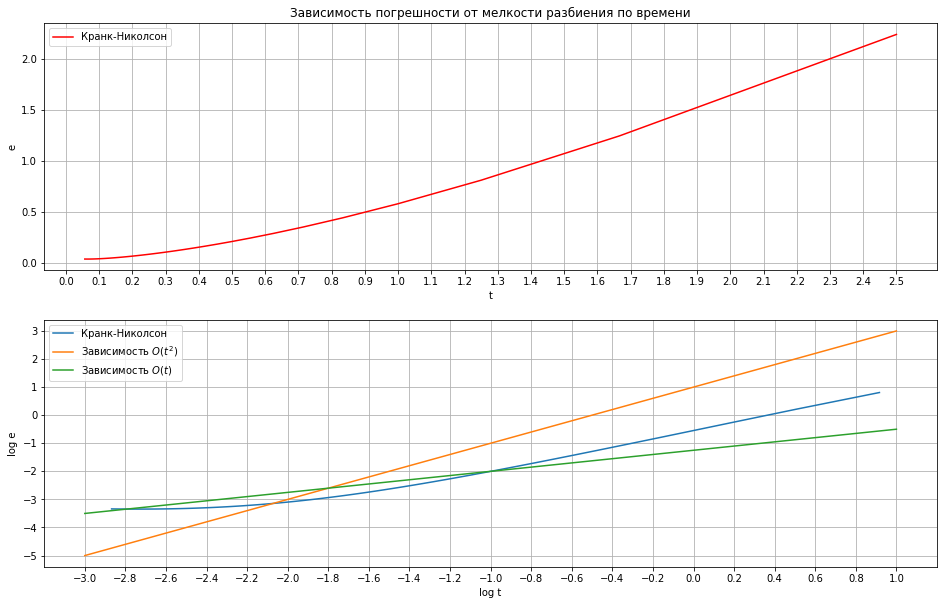

In [41]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(krank, u)

plt.plot(tau, e, label="Кранк-Николсон", color = "red")
plt.xlabel("t")
plt.ylabel("e")
# plt.ylim([0, 2.1])
plt.xticks(list(krank.nparange(0, 2.5, 0.1)))
# plt.yticks(list(implict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Кранк-Николсон")
plt.plot([-3, 1], [-5, 3], label="Зависимость $O(t^2)$")
plt.plot([-3, 1], [-3.5, -0.5], label="Зависимость $O(t)$")
plt.xlabel("log t")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2, 0.5])
plt.xticks(list(krank.nparange(-3, 1, 0.2)))
# plt.yticks(list(implict.nparange(-3, 1, 0.2)))

plt.legend()
plt.grid()

<h3><center> Графическая иллюстрация </center></h3>

#### Сетка для реальной функции

In [42]:
def real_z(l0, l1, T, f):
    x = np.arange(l0, l1 + 0.005, 0.005)
    y = np.arange(0, T + 0.005, 0.005)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j])
    return X, Y, Z

#### Явная схема

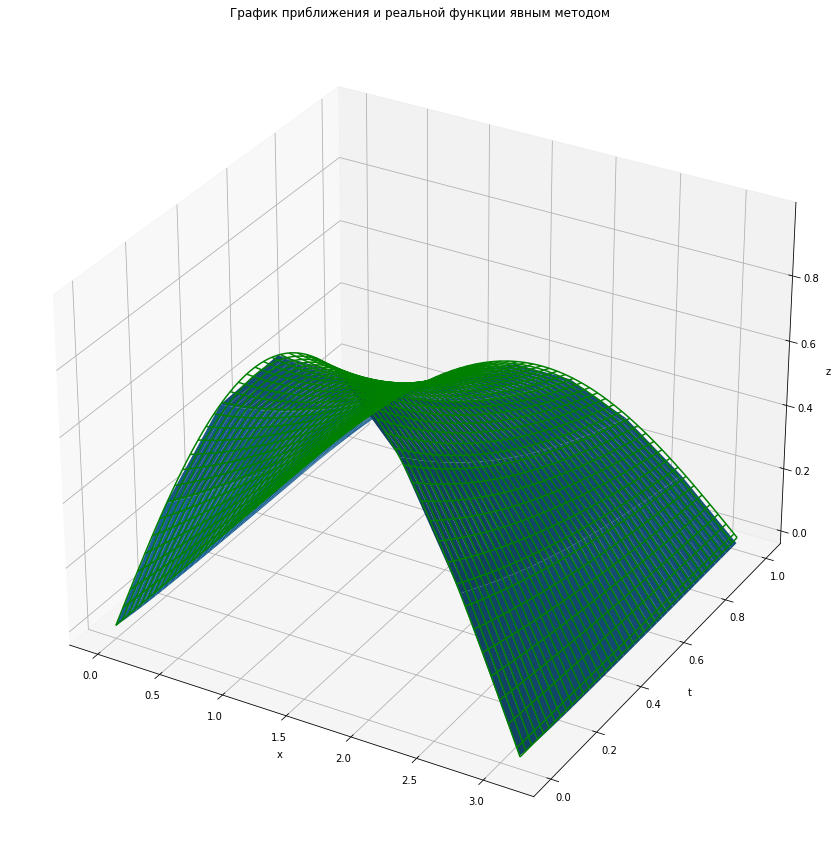

In [43]:
def plot_1(a = 1):
    schema = Explict_Schema(T = 1, aprx_cls=approx_two_two, a=a)
    x, y, z = schema(N = 8, K = 40)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, math.pi, 1, lambda i, j: u(i, j, a)), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции явным методом')
    fig.tight_layout()

interact(plot_1, a=(1, 5, 1))
None

#### Неявная схема

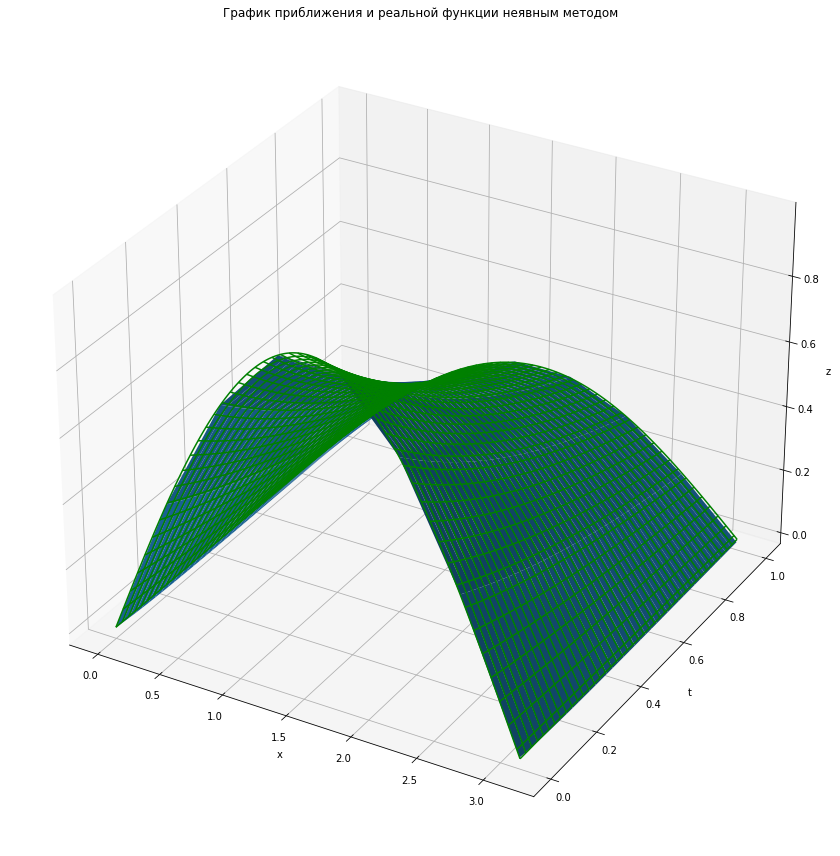

In [44]:
def plot_2(a = 1):
    schema = Krank_Nikolson(T = 1, aprx_cls=approx_two_two, a=a, O = 1)
    x, y, z = schema(N = 8, K = 40)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, math.pi, 1, lambda i, j: u(i, j, a)), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции неявным методом')
    fig.tight_layout()

interact(plot_2, a=(1, 5, 1))
None

#### Схема Кранка-Николсона

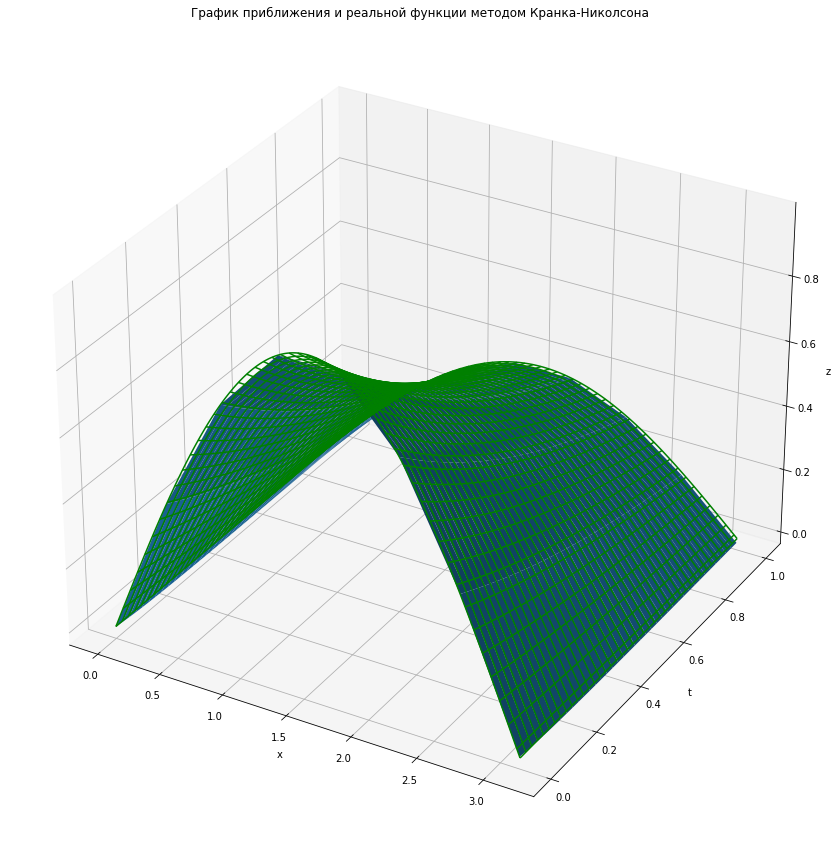

In [45]:
def plot_3(a = 1):
    schema = Krank_Nikolson(T = 1, aprx_cls=approx_two_two, a=a, O = 0.5)
    x, y, z = schema(N = 8, K = 40)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, math.pi, 1, lambda i, j: u(i, j, a)), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции методом Кранка-Николсона')
    fig.tight_layout()

interact(plot_3, a=(1, 5, 1))
None